# Interpolace
Vykreslení výsledků z genetického algoritmu. Pro různé běhy si ukládáme, v jaké generaci a o kolik se zvýšila fitness hodnota. Máme celkem 20 běhů s různými generacemi, kde došlo ke změně.

## Načítání dat
Načteme data ze souborů v archivu [runs.zip](runs.zip). Každý soubor má následující formát:
```
gen=0,fit=0.00
gen=3,fit=0.04
gen=7,fit=0.04
gen=20,fit=0.09
gen=21,fit=0.33
gen=27,fit=0.49
gen=35,fit=0.53
gen=89,fit=0.68
gen=90,fit=0.74
```

Pro dekódování použijeme 2x zanořenou funkci `map`, která ve vyšší úrovni rozdělí řádky podle čárek a v nižší podle '='. Tento soubor potom převede rovnou na následující zápis
```
[
    {("gen", "0"), ("fit", "0.00")},
    {("gen", "3"), ("fit", "0.04")},
    {("gen", "7"), ("fit", "0.04")},
    {("gen", "20"), ("fit", "0.09")},
    {("gen", "21"), ("fit", "0.33")},
    {("gen", "27"), ("fit", "0.49")},
    {("gen", "35"), ("fit", "0.53")},
    {("gen", "89"), ("fit", "0.68")},
    {("gen", "90"), ("fit", "0.74")}
]
```

Potom se vytvoří `pd.DataFrame`, sloupce se hromadně konvertují a přidá se informace o běhu. Všechny tyto postupy byste měli znát z předcházejících přednášek


In [2]:
###
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# načtení dat (viz popis nahoře)
alld = []
with ZipFile("runs.zip") as zf:
    for fn in zf.namelist():
        with zf.open(fn) as f:
            # dekodovani gen=X,fit=XX
            df_loc = pd.DataFrame(list(map(
                lambda x: dict(map(lambda y: tuple(y.split("=")),
                                   x.decode().strip().split(","))),
                f.readlines()
            )))
            df_loc["gen"] = df_loc["gen"].astype("i")
            df_loc["fit"] = df_loc["fit"].astype("f")
            df_loc["run"] = fn
            alld.append(df_loc)

df = pd.concat(alld, ignore_index=True)
df


,gen,fit,run
0,0,0.00,run_000.log
1,3,0.04,run_000.log
2,7,0.04,run_000.log
3,20,0.09,run_000.log
4,21,0.33,run_000.log
...,...,...,...
218,19,0.40,run_019.log
219,65,0.52,run_019.log
220,66,0.71,run_019.log
221,68,0.80,run_019.log


<AxesSubplot: xlabel='gen', ylabel='fit'>

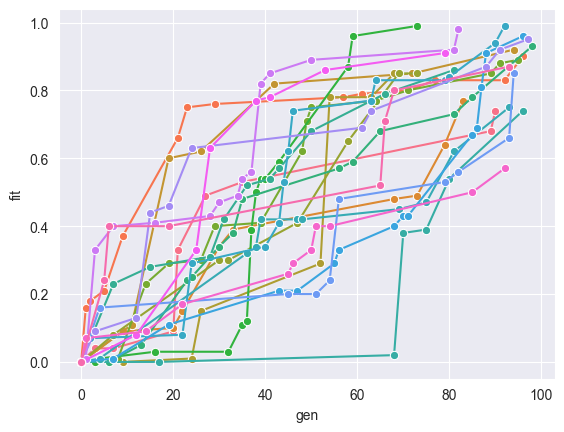

In [3]:
###
# Jak data vypadají?
sns.lineplot(data=df, x="gen", y="fit", hue="run", marker="o", legend=False)


## Konvergence
Nyní chceme určit tzv. konvergenci - tj. jak se mění fitness v průběhu generací. Nejlépe by bylo zobrazit i _confidence interval_ pro určení 95% rozsahu.

<AxesSubplot: xlabel='gen', ylabel='fit'>

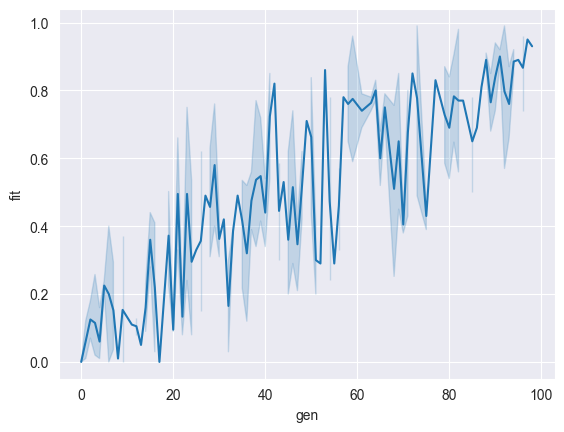

In [4]:
# Zobrazit konvergenční křivku pro dataframe df
sns.lineplot(data=df, x="gen", y="fit", legend=False)


V grafu ale vznikly škaredé skoky. Ty jsou způsobené tím, že počet záznamů pro každou generaci je rozdílný (měl by být 20, což je počet skoků).

     gen   fit          run
0      0  0.00  run_000.log
1      3  0.04  run_000.log
2      7  0.04  run_000.log
3     20  0.09  run_000.log
4     21  0.33  run_000.log
..   ...   ...          ...
218   19  0.40  run_019.log
219   65  0.52  run_019.log
220   66  0.71  run_019.log
221   68  0.80  run_019.log
222   93  0.87  run_019.log

[223 rows x 3 columns]
    gen  fit  run
0     0   20   20
1     1    4    4
2     2    2    2
3     3    4    4
4     4    3    3
..  ...  ...  ...
85   94    2    2
86   95    1    1
87   96    3    3
88   97    1    1
89   98    1    1

[90 rows x 3 columns]


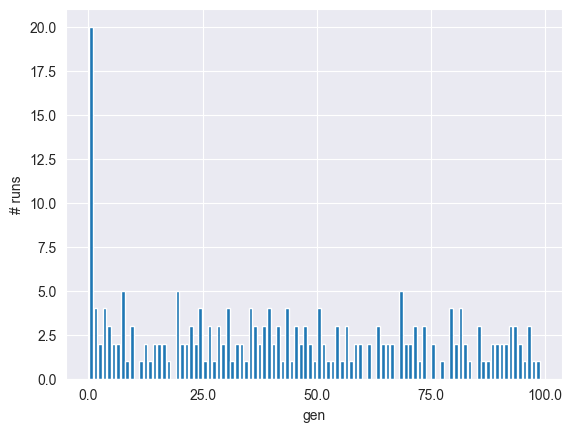

In [5]:
###
print(df)
dfv = df.groupby("gen").count().reset_index()
print(dfv)
plt.bar(dfv["gen"] + 0.5, dfv["run"])
_ = plt.gca().set(xticks=np.linspace(0, 100, num=5), xticklabels=np.linspace(0, 100, num=5),
                  ylabel="# runs", xlabel="gen")


## Interpolace pro všechny generace
Proto musíme vytvořit nový DataFrame, který pro všechny generace má uvedenou fitness.

In [5]:
from scipy.interpolate import interp1d
# Vytvoříme si nový prostor X - který může být např:
#  - celý prostorn 0 - 100
#  - unikátní hodnoty gen v datasetu df
#  - unikátní hodnoty gen a hodnoty gen - delta v df
#  - ...
X = np.linspace(0, 100, 101)

# pro všechny běhy vytvoříme nový DataFrame se správnými hodnotami fitness
# použijeme 1D interpolaci i s extrapolací tak, že interpolujeme předchozí hodnotou
alld = []
for r, d in df.groupby("run"):
    f = interp1d(d["gen"], d["fit"], kind="previous", fill_value="extrapolate")
    df_loc = pd.DataFrame({"gen": X, "fit": f(X)})
    df_loc["run"] = r
    alld.append(df_loc)
df2 = pd.concat(alld)
df2


,gen,fit,run
0,0.0,0.00,run_000.log
1,1.0,0.00,run_000.log
2,2.0,0.00,run_000.log
3,3.0,0.04,run_000.log
4,4.0,0.04,run_000.log
...,...,...,...
96,96.0,0.87,run_019.log
97,97.0,0.87,run_019.log
98,98.0,0.87,run_019.log
99,99.0,0.87,run_019.log


Nyní se podíváme na to, jak celý nový dataset vypadá. Všimneme si toho, jak jsou tvořeny schody a že funkce jsou nyní definované až do konce

<AxesSubplot:xlabel='gen', ylabel='fit'>

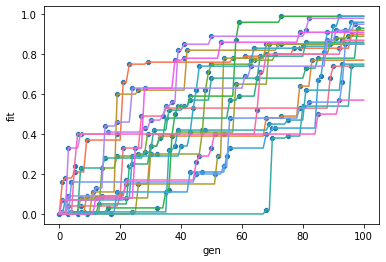

In [6]:
# Vykreslení čárového grafu z df2 a přes něj vykreslený scatterplot starého dataframe df
ax = sns.lineplot(data=df2, x="gen", y="fit", hue="run", legend=False)
sns.scatterplot(data=df, x="gen", y="fit")  # puvodni hodnoty


## Vykreslení konvergenční křivky
Nyní můžeme vykreslit celou konvergenční křivku, nechat z ní spočítat průměr a confidence interval. Jsou samozřejmě možné další modifikace - jako např. zobrazit medián.

<AxesSubplot:xlabel='gen', ylabel='fit'>

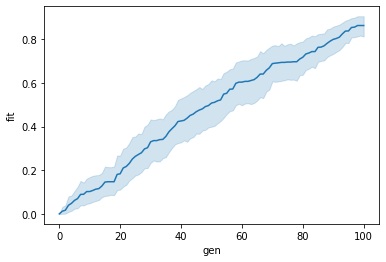

In [7]:
# Vykreslení konvergenční křivky
sns.lineplot(data=df2, x="gen", y="fit", legend=False)


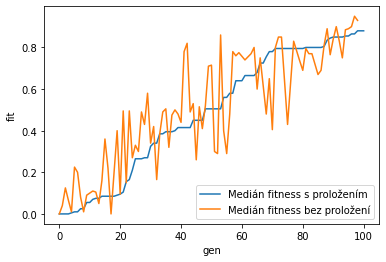

In [8]:
###
# Vykreslení mediánů starých dat a prokládaných dat.
ax = sns.lineplot(data=df2, x="gen", y="fit", legend=False,
                  estimator=np.median, ci=None, label="Medián fitness s proložením")
sns.lineplot(data=df, x="gen", y="fit", legend=False, ax=ax,
             estimator=np.median, ci=None, label="Medián fitness bez proložení")
plt.legend()


Hotovo!